In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/mesonet/MesoNet-master

/content/gdrive/My Drive/mesonet/MesoNet-master


In [12]:
!ls

classifiers.py	LICENSE        NOTICE	    __pycache__  test_images  vid1.mp4
example.py	MesoNet.ipynb  pipeline.py  README.md	 test_vids    weights


In [5]:
#pip install ffmpeg
!pip install face_recognition

     |████████████████████████████████| 100.2MB 109kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=e41724f2a15fa042d78d979c59e6aa7abfc6ab6bd240821b811be3c7432bbc51
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [6]:
from pipeline import *

In [4]:
# Detecting POI in the videos using face_recognition lib

#vid_dir = 'test_vids/vid1.mp4'

frec_obj = FaceFinder('vid1.mp4')

In [20]:
face1 = frec_obj.get_face(1)
face1_align = frec_obj.get_aligned_face(2, l_factor = 0.5)

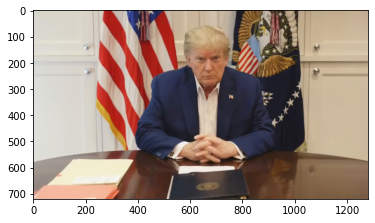

In [14]:
import matplotlib.pyplot as plt

plt.imshow(face1)
plt.show()

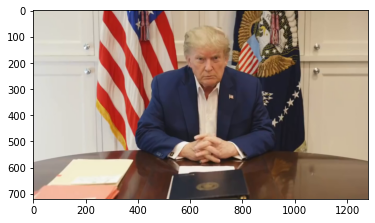

In [21]:
plt.imshow(face1_align)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [30]:
# Define a classifier class
class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [32]:
# Meso1 Classifier
class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)

In [33]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [34]:
class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [71]:
IMGWIDTH = 256
meso = Meso4()
mesoIncep = MesoInception4()
meso.load('./weights/Meso4_DF')
mesoIncep.load('./weights/MesoInception_DF')

In [64]:
data_gen = ImageDataGenerator(rescale=1./255)
generator = data_gen.flow_from_directory(
    'deepfake_database/validation',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [65]:
generator.class_indices

{'df': 0, 'real': 1}

In [66]:
X, y = generator.next()

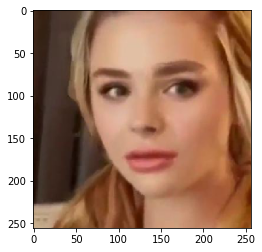

In [67]:
plt.imshow(np.squeeze(X))

In [70]:
print("Confidence")
pred = meso.predict(X)[0][0]
print(pred)
if round(pred) == 1:
  print("Predicted Label: Real")
else: print('Predicted Label: Fake')
if y[0] == 1:
  print("Actual Label: Real")
else: print("Actual Label: Fake")
if round(meso.predict(X)[0][0])==y[0]:
  print(" ***** Correct Prediction ***** ")
else: print(" ***** Incorrect Prediction ****** ")

Confidence
0.35055357
Predicted Label: Fake
Actual Label: Fake
 ***** Correct Prediction ***** 


In [72]:
print("Confidence")
pred2 = mesoIncep.predict(X)[0][0]
print(pred2)
if round(pred2) == 1:
  print("Predicted Label: Real")
else: print('Predicted Label: Fake')
if y[0] == 1:
  print("Actual Label: Real")
else: print("Actual Label: Fake")
if round(mesoIncep.predict(X)[0][0])==y[0]:
  print(" ***** Correct Prediction ***** ")
else: print(" ***** Incorrect Prediction ****** ")

Confidence
0.0071575483
Predicted Label: Fake
Actual Label: Fake
 ***** Correct Prediction ***** 


In [26]:
import json

with open('fb_data/train/metadata.json') as f:
  data = json.load(f)

In [36]:
import shutil
import os.path
from os import path

In [63]:
# Using Metadata to identify real and fake files
src = 'fb_data/train/'
dest1 = 'fb_data/train/REAL/'
dest2 = 'fb_data/train/FAKE/'
re_files = []
fk_files = []
for key in data.keys():
  if data[key]['label'] == 'REAL':
    source = src + str(key)
    if path.exists(source):
      print('Label is ' + str(data[key]['label']))
      re_files.append(key)
      destination = dest1 
      shutil.move(source, destination)
      print('{Real}: Moved '+str(key)+' to   '+ str(destination))

  else: 
    source = src + str(key)
    if path.exists(source):
      print('Label is ' + str(data[key]['label']))
      fk_files.append(key)
      destination = dest2 
      shutil.move(source, destination)
      print('{Fake}: Moved '+str(key)+' to   '+str(destination))


Label is FAKE
{Fake}: Moved aagfhgtpmv.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved aapnvogymq.mp4 to   fb_data/train/FAKE/
Label is REAL
{Real}: Moved abarnvbtwb.mp4 to   fb_data/train/REAL/
Label is FAKE
{Fake}: Moved abofeumbvv.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved abqwwspghj.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved acifjvzvpm.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved acqfdwsrhi.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved acxnxvbsxk.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved acxwigylke.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved aczrgyricp.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved adhsbajydo.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved adohikbdaz.mp4 to   fb_data/train/FAKE/
Label is FAKE
{Fake}: Moved adylbeequz.mp4 to   fb_data/train/FAKE/
Label is REAL
{Real}: Moved aelfnikyqj.mp4 to   fb_data/train/REAL/
Label is FAKE
{Fake}: Moved aelzhcnwgf.mp4 to   

In [49]:
from classifiers import *
from pipeline import *

In [59]:
# for k,v in data.items():
#   print(v['label'])

In [67]:
# print each data item. 
print ("{:<10} {:<10}".format('FILE NAME', '    LABEL'))
for f in re_files: 
    name = f
    print ("{:<10} {:<10}".format(name, 'REAL')) 

FILE NAME      LABEL 
abarnvbtwb.mp4 REAL      
aelfnikyqj.mp4 REAL      
afoovlsmtx.mp4 REAL      


In [68]:
# Testing on Real Files
classifier = Meso4()
classifier.load('weights/Meso4_F2F')

predictions = compute_accuracy(classifier, dest1)
for video_name in predictions:
    print('`{}` video class prediction :'.format(video_name), predictions[video_name][0])

Dealing with video  afoovlsmtx.mp4
Face extraction warning :  0 - found face in full frame [(732, 577, 1010, 300)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  afoovlsmtx.mp4
Dealing with video  aelfnikyqj.mp4
Face extraction warning :  0 - found face in full frame [(83, 1011, 194, 899)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  aelfnikyqj.mp4
Dealing with video  abarnvbtwb.mp4
Face extraction warning :  0 - found face in full frame [(208, 999, 401, 807)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  abarnvbtwb.mp4
`afoovlsmtx` video class prediction : 1.0
`aelfnikyqj` video class prediction : 1.0
`abarnvbtwb` video class prediction : 1.0


In [69]:
# print each data item. 
print ("{:<10} {:<10}".format('FILE NAME', '    LABEL'))
for f in fk_files: 
    name = f
    print ("{:<10} {:<10}".format(name, 'FAKE'))

FILE NAME      LABEL 
aagfhgtpmv.mp4 FAKE      
aapnvogymq.mp4 FAKE      
abofeumbvv.mp4 FAKE      
abqwwspghj.mp4 FAKE      
acifjvzvpm.mp4 FAKE      
acqfdwsrhi.mp4 FAKE      
acxnxvbsxk.mp4 FAKE      
acxwigylke.mp4 FAKE      
aczrgyricp.mp4 FAKE      
adhsbajydo.mp4 FAKE      
adohikbdaz.mp4 FAKE      
adylbeequz.mp4 FAKE      
aelzhcnwgf.mp4 FAKE      
aettqgevhz.mp4 FAKE      
aevrfsexku.mp4 FAKE      
agdkmztvby.mp4 FAKE      
agqphdxmwt.mp4 FAKE      


In [74]:
predictions = compute_accuracy(classifier, dest2)
for video_name in predictions:
    print('`{}` video class prediction :'.format(video_name), predictions[video_name][0])

Dealing with video  agqphdxmwt.mp4
Face extraction warning :  0 - found face in full frame [(83, 1147, 194, 1036)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  agqphdxmwt.mp4
Dealing with video  aelzhcnwgf.mp4
Face extraction warning :  0 - found face in full frame [(138, 975, 298, 815)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  aelzhcnwgf.mp4
Dealing with video  abqwwspghj.mp4
Face extraction warning :  0 - found face in full frame [(123, 999, 315, 807)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  abqwwspghj.mp4
Dealing with video  aevrfsexku.mp4
Face extraction warning :  0 - found face in full frame [(123, 914, 315, 721)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  aevrfsexku.mp4
Dealing with video  aagfhgtpmv.mp4
Face extraction warning :  0 - found face in full frame [(178, 608, 455, 331)]
Face extr

In [102]:
# import cv2 

# def visualizer(images,preds):
#     for j in range(len(images)):
#       print
#       cap = cv2.VideoCapture(images[j])
#       if (cap.isOpened()== False):  
#         print("Error opening video  file")
#       while cap.isOpened():
#         ret, frame = cap.read() 
#         if ret == True: 
#           cv2.imshow('Frame', frame) 
#           if cv2.waitKey(25) & 0xFF == ord('q'): 
#             break
#         else:
#           break
#       cap.release()
#       print("Model confidence: " + str(preds[images[j][:-4]][0]))
#     return